<a href="https://colab.research.google.com/github/seoyujiin/esaa_ob/blob/main/%EC%BA%90%EA%B8%80_%ED%95%84%EC%82%AC_%EB%B9%84%EC%A7%80%EB%8F%84_%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Customers clustering: K-Means, DBSCAN and AP**

https://www.kaggle.com/code/datark1/customers-clustering-k-means-dbscan-and-ap/input

##1. Introduction

* One of the most known application of clustering:
  * customers segmentation(for efficient marketing)
  * image segmentation
  * documents clusterisation
* two main types of clustering algorithms:
  * Hierarchical algorithms(계층적 알고리즘)
  * Partitional algorithms(분할 알고리즘)

##2. Reading data

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("seaborn version: {}".format(sns.__version__))

pandas version: 1.5.3
numpy version: 1.23.5
seaborn version: 0.12.2


In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
mall_data = pd.read_csv('/content/drive/MyDrive/ESAA/OB/data/Mall_Customers.csv')

print('There are {} rows and {} columns in our dataset.'.format(mall_data.shape[0],mall_data.shape[1]))

There are 200 rows and 5 columns in our dataset.


In [60]:
mall_data.sample(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
36,37,Female,42,34,17
183,184,Female,29,98,88
64,65,Male,63,48,51
85,86,Male,48,54,46
186,187,Female,54,101,24
74,75,Male,59,54,47
88,89,Female,34,58,60
175,176,Female,30,88,86
48,49,Female,29,40,42
187,188,Male,28,101,68


In [61]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


* There are 5 columns:
  * Customer ID - numerical - unique customer number - integer
  * Gender - categorical - binary (Male/Female)
  * Age - numerical - integer
  * Annual Income (k$) - numerical - integer
  * Spending Score (1-100) - numerical - integer

→ There are one binary, categorical column: gender

* You may be tempted to one-hot encode it for the clustering:
  * technically possible
  * theoretically not forbidden
  * practically not recommended


In [62]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [63]:
mall_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

→ There are no missing data.

##3. Exploratory Data Analysis(EDA)

* 주어진 데이터베이스에 대한 basic statistical investigation
* 두 가지 주요 섹션: distributions and correlations


###3.1 Distributions

수치형 변수의 분포를 조사함(유일한 범주형 변수인 성별에 따라 계층화됨)

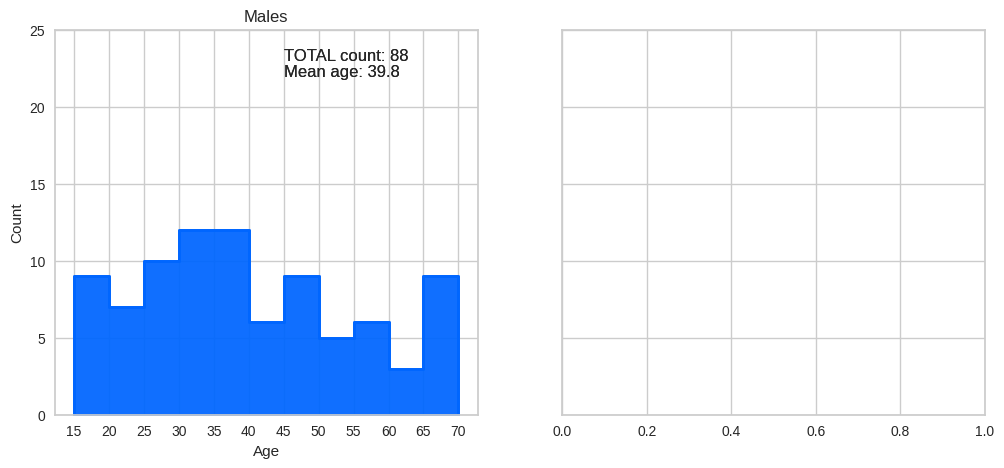

In [64]:
males_age = mall_data[mall_data['Gender']=='Male']['Age'] # subset with males age
females_age = mall_data[mall_data['Gender']=='Female']['Age'] # subset with females age

age_bins = range(15,75,5)

# males histogram
fig2, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.histplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=axes[0], element='step', linewidth=2)
axes[0].set(xticks=age_bins, ylim=(0, 25), title='Males', ylabel='Count')
axes[0].text(45, 23, f"TOTAL count: {males_age.count()}")
axes[0].text(45, 22, f"Mean age: {males_age.mean():.1f}")


# females histogram
sns.histplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=axes[0], element='step', linewidth=2)
axes[0].set(xticks=age_bins, ylim=(0, 25), title='Males', ylabel='Count')
axes[0].text(45, 23, f"TOTAL count: {males_age.count()}")
axes[0].text(45, 22, f"Mean age: {males_age.mean():.1f}")

plt.show()

In [65]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_age, females_age)[1]))

Kolgomorov-Smirnov test p-value: 0.49


→ 남성 고객의 평균 연령 > 여성 고객의 평균 연령

→ 남성 연령의 분포는 여성보다 더 균일함(가장 큰 연령대는 30-35세)

→ Kolgomorov-Smirnov 검정은 이 두 그룹 간의 차이가 통계적으로 유의하지 않음을 보여줌

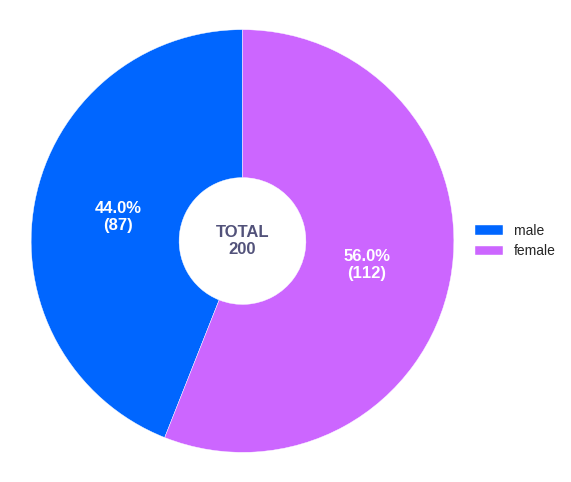

In [66]:
def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [males_age.count(),females_age.count()] # wedge sizes

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#0066ff','#cc66ff'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male','female'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(mall_data['Age'].count()),
         weight='bold', size=12, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  # Equal aspect ratio
plt.show()

→ 여성 고객이 남성 고객보다 많음. 전체 고객 중 여성이 56%

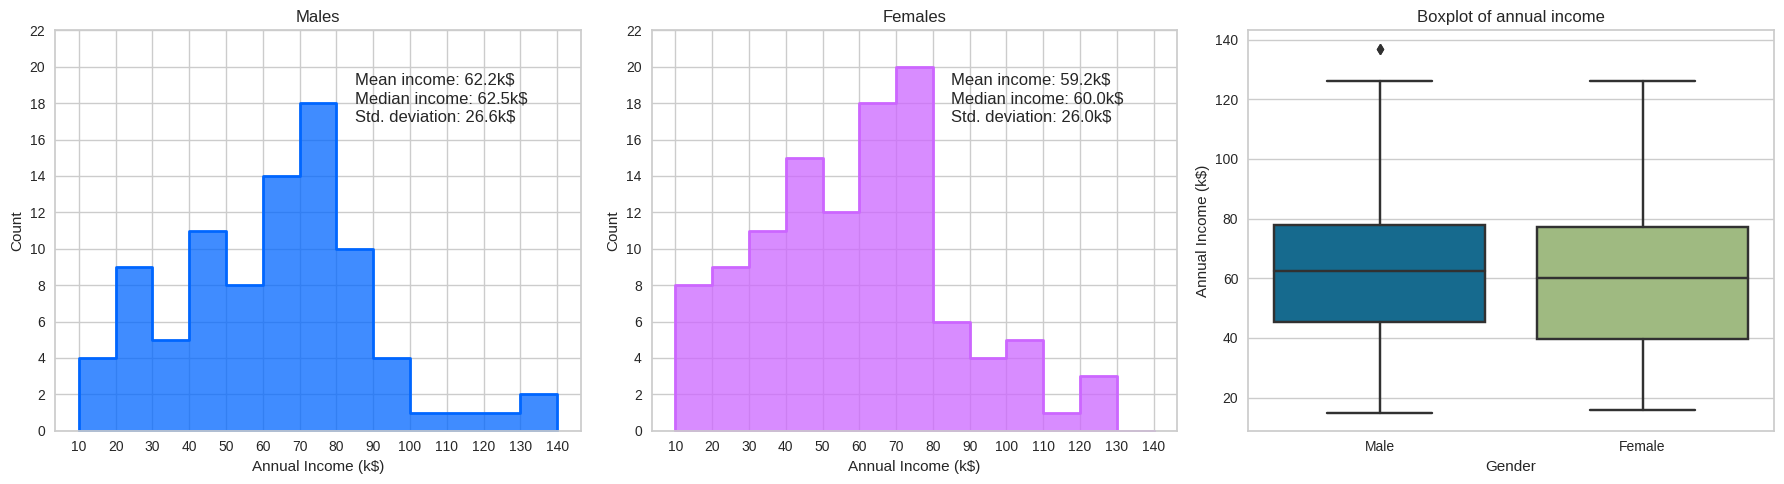

In [67]:
males_income = mall_data[mall_data['Gender']=='Male']['Annual Income (k$)'] # subset with males income
females_income = mall_data[mall_data['Gender']=='Female']['Annual Income (k$)'] # subset with females income

my_bins = range(10,150,10)

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# males histogram
sns.histplot(data=males_income, bins=my_bins, kde=False, color='#0066ff', ax=axes[0], element='step', linewidth=2)
axes[0].set(xticks=my_bins, yticks=range(0, 24, 2), ylim=(0, 22), title='Males', ylabel='Count')
axes[0].text(85, 19, f"Mean income: {males_income.mean():.1f}k$")
axes[0].text(85, 18, f"Median income: {males_income.median():.1f}k$")
axes[0].text(85, 17, f"Std. deviation: {males_income.std():.1f}k$")

# females histogram
sns.histplot(data=females_income, bins=my_bins, kde=False, color='#cc66ff', ax=axes[1], element='step', linewidth=2)
axes[1].set(xticks=my_bins, yticks=range(0, 24, 2), ylim=(0, 22), title='Females', ylabel='Count')
axes[1].text(85, 19, f"Mean income: {females_income.mean():.1f}k$")
axes[1].text(85, 18, f"Median income: {females_income.median():.1f}k$")
axes[1].text(85, 17, f"Std. deviation: {females_income.std():.1f}k$")

# boxplot
sns.boxplot(x='Gender', y='Annual Income (k$)', data=mall_data, ax=axes[2])
axes[2].set_title('Boxplot of annual income')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()


In [68]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_income, females_income)[1]))

Kolgomorov-Smirnov test p-value: 0.78


→ 남성의 평균 소득 > 여성의 평균 소득

→ 남성 고객의 중위소득(62.5k$) > 여성 고객의 중위소득(60k$)

→ 표준편차는 두 그룹에서 유사함

→ 남성 그룹에서 한 명의 이상치 존재

→ K-S 검정 결과 이 두 그룹은 통계적으로 다르지 않은 것으로 나타남

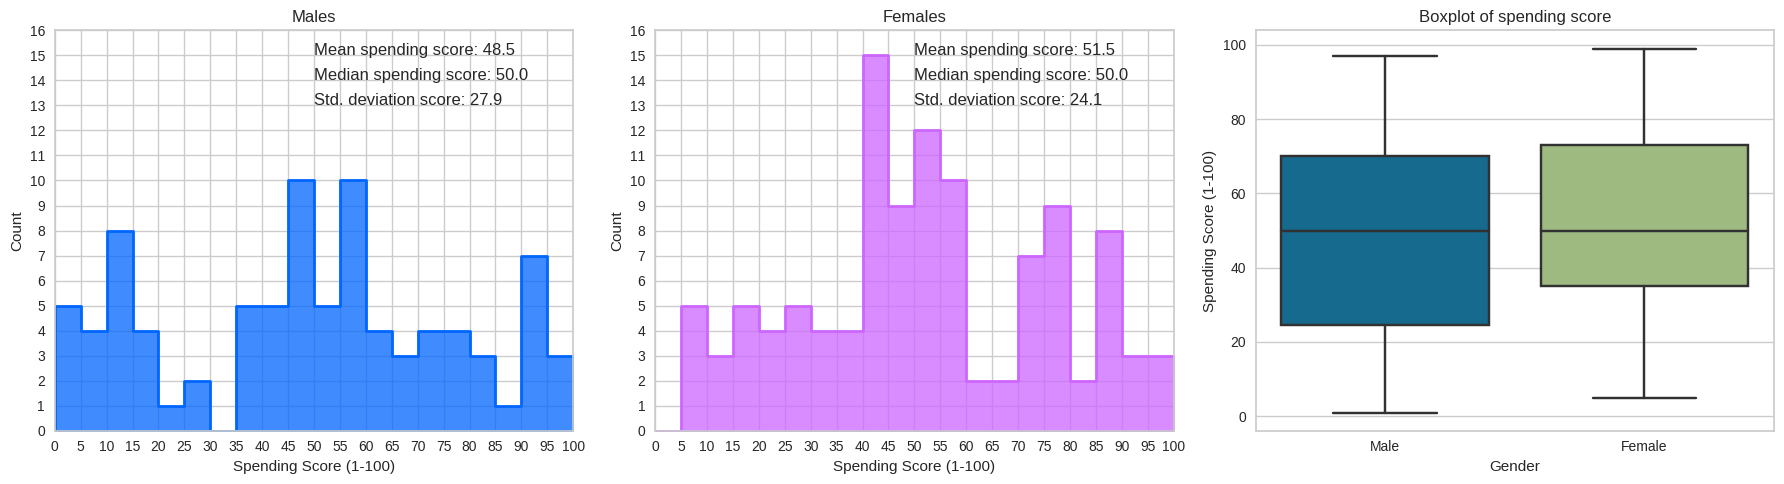

In [69]:
males_spending = mall_data[mall_data['Gender']=='Male']['Spending Score (1-100)'] # subset with males age
females_spending = mall_data[mall_data['Gender']=='Female']['Spending Score (1-100)'] # subset with females age

spending_bins = range(0,105,5)

# create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))


# males histogram
sns.histplot(data=males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=axes[0], element='step', linewidth=2)
axes[0].set(xticks=spending_bins, xlim=(0, 100), yticks=range(0, 17, 1), ylim=(0, 16), title='Males', ylabel='Count')
axes[0].text(50, 15, f"Mean spending score: {males_spending.mean():.1f}")
axes[0].text(50, 14, f"Median spending score: {males_spending.median():.1f}")
axes[0].text(50, 13, f"Std. deviation score: {males_spending.std():.1f}")


# females histogram
sns.histplot(data=females_spending, bins=spending_bins, kde=False, color='#cc66ff', ax=axes[1], element='step', linewidth=2)
axes[1].set(xticks=spending_bins, xlim=(0, 100), yticks=range(0, 17, 1), ylim=(0, 16), title='Females', ylabel='Count')
axes[1].text(50, 15, f"Mean spending score: {females_spending.mean():.1f}")
axes[1].text(50, 14, f"Median spending score: {females_spending.median():.1f}")
axes[1].text(50, 13, f"Std. deviation score: {females_spending.std():.1f}")


# boxplot
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=mall_data, ax=axes[2])
axes[2].set_title('Boxplot of spending score')

# adjust spacing between subplots
plt.tight_layout()
plt.show()

In [70]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_spending, females_spending)[1]))

Kolgomorov-Smirnov test p-value: 0.29


→ 평균 지출 점수는 여성(51.5)이 남성(48.5)보다 높음

→ K-S 검정 p-value는 귀무가설을 기각할 증거가 없음을 나타내지만 증거는 이전 비교처럼 강력하지 않음

In [71]:
# 모든 연령대의 중위소득 계산
medians_by_age_group = mall_data.groupby(["Gender",pd.cut(mall_data['Age'], age_bins)]).median()
medians_by_age_group.index = medians_by_age_group.index.set_names(['Gender', 'Age_group'])
medians_by_age_group.reset_index(inplace=True)

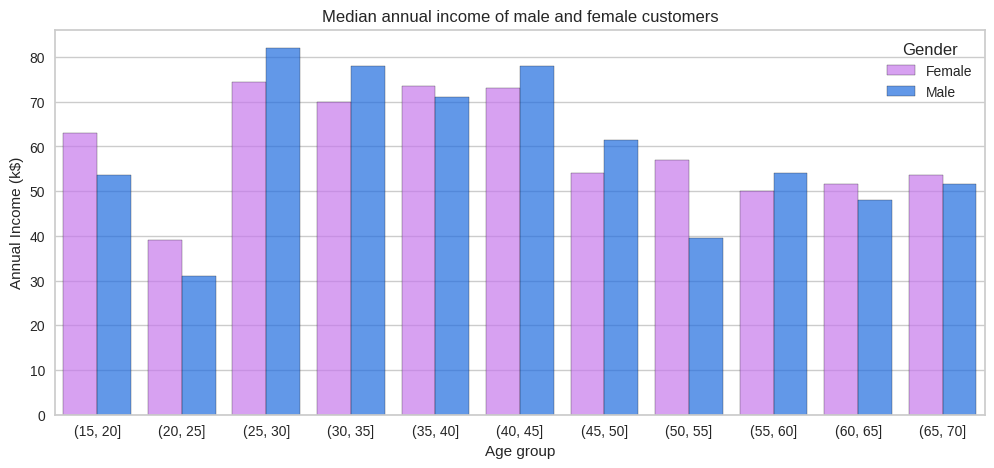

In [72]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x='Age_group', y='Annual Income (k$)', hue='Gender', data=medians_by_age_group,
            palette=['#cc66ff','#0066ff'],
            alpha=0.7,edgecolor='k',
            ax=ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

→ 가장 부유한 고객이 25-45세

→ 여성과 남성의 가장 큰 차이는 25-30세(남성이 더 부유함)와 50-55세(여성이 더 부유함) 연령대에서 볼 수 있음

###3.2 Correlations

수치형 변수 간의 상관관계

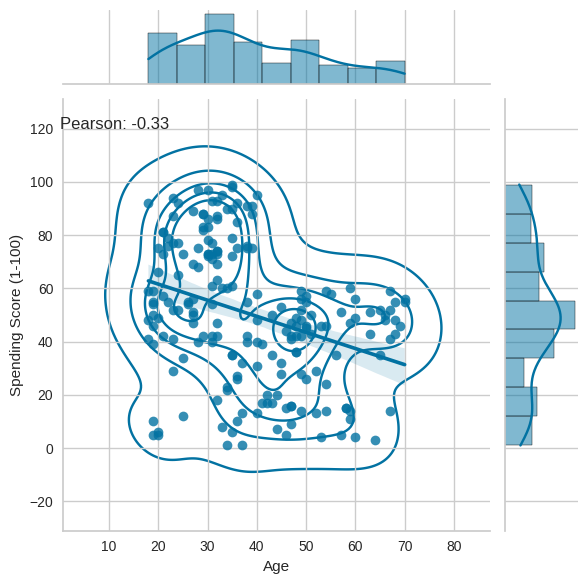

In [73]:
from scipy.stats import pearsonr

# calculating Pearson's correlation
corr, _ = pearsonr(mall_data['Age'], mall_data['Spending Score (1-100)'])

jp = (sns.jointplot(x='Age', y='Spending Score (1-100)', data=mall_data,
                    kind='reg')).plot_joint(sns.kdeplot, zorder=0, n_levels=6)

plt.text(0,120, 'Pearson: {:.2f}'.format(corr))
plt.show()

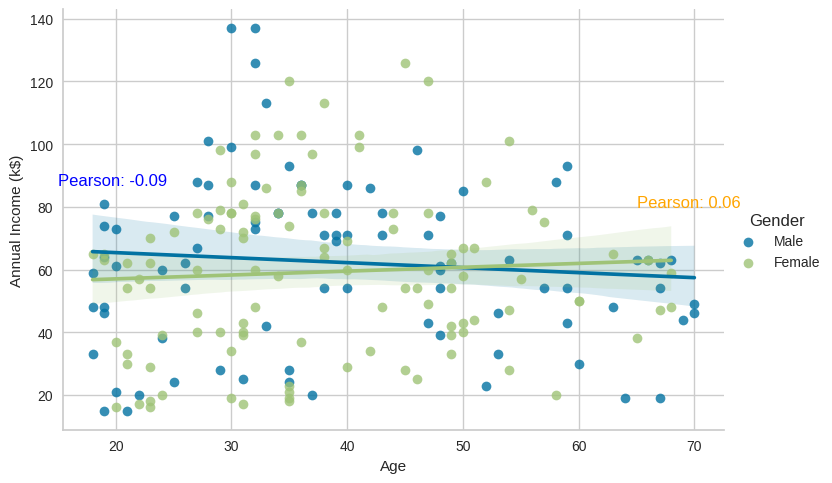

In [74]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_income.values)
corr2, _ = pearsonr(females_age.values, females_income.values)

sns.lmplot(x='Age', y='Annual Income (k$)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(15,87, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(65,80, 'Pearson: {:.2f}'.format(corr2), color='orange')

plt.show()

→ 두 성별 그룹 모두 고객의 연령과 연소득 사이에는 무시할만한 상관관계가 있음

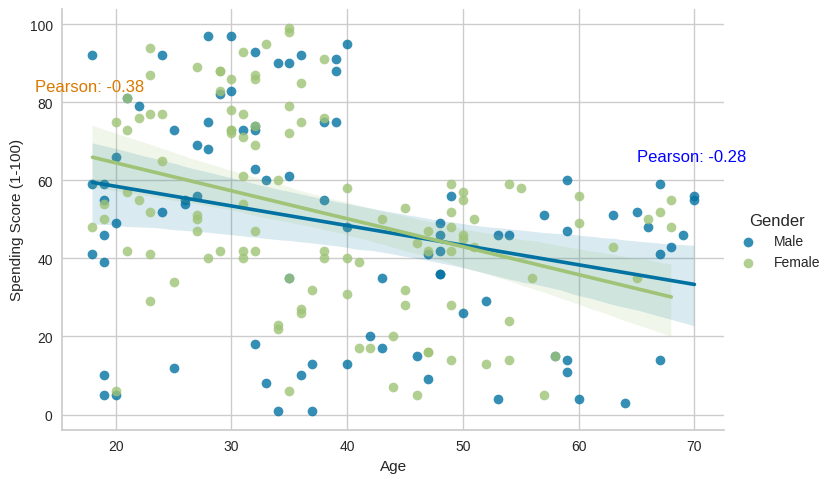

In [75]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_spending.values)
corr2, _ = pearsonr(females_age.values, females_spending.values)

sns.lmplot(x='Age', y='Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(65,65, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(13,83, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

→ 두 성별 그룹의 연령과 소비(지출) 점수 사이에는 약한 음의 상관관계(<0.5)가 있음

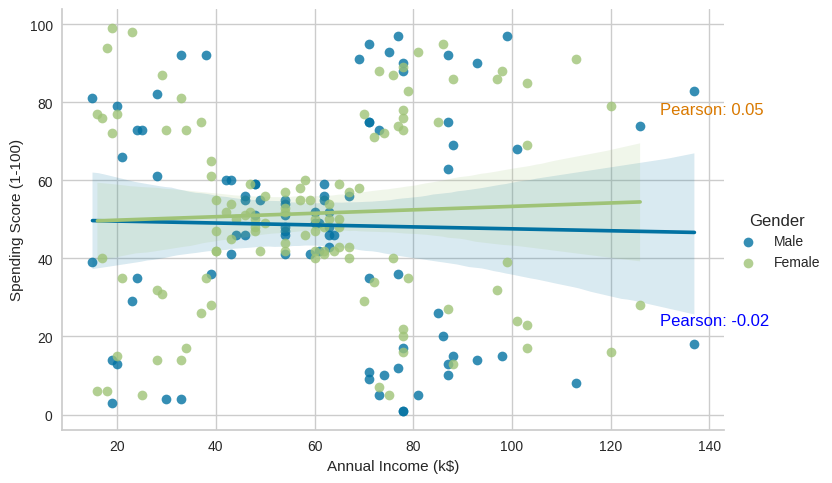

In [76]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_income.values, males_spending.values)
corr2, _ = pearsonr(females_income.values, females_spending.values)

sns.lmplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(130,23, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(130,77, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

→ 두 성별 그룹의 연소득과 소비(지출) 점수 사이에는 무시할 수 있는 상관관계가 있음

##4. Clustering

* 3개의 군집 알고리즘
  * K-Means
  * Density-Based Spatial Clustering of Applications with Noise(DBSCAN)
  * Affinity Propagation

###4-1. K-Means

이 장에서는 대부분의 머신러닝 과정에서 매우 인기있는 K-Means 알고리즘에 초점을 맞춤

####4.1.1 Description

* 가장 잘 알려진 분할 군집 알고리즘은 K-Means
* 3가지 주요 단계
  1. Split samples into initial groups by using seed points. The nearest samples to these seed point will create initial clusters.
  2. Calculate samples distances to groups’ central points (centroids) and assign the nearest samples to their cluster.
  3. The third step is to calculate newly created (updated) cluster centroids.
  * 2, 3번을 알고리즘이 수렴할 때까지 반복
* K-Means의 목표: 모든 군집에 걸쳐 objective function(inertia)를 최소화하는 것

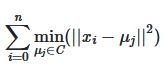

####4.1.2 Use case - customers segmentation

In [77]:
from sklearn.cluster import KMeans

* 군집화의 경우 numerical columns만 사용되므로 이진 변수인 성별은 사용x

In [78]:
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] # subset with numeric variables only

* 적절한 수의 클러스터를 찾기 위해 elbow method(팔꿈치 방법)를 사용
  * 2에서 10 사이의 다수의 클러스터에 대한 관성(inertia) 계산될 것
  * 그래프에서 꺾임이나 "elbow"가 나타나는 군집의 수를 선택

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

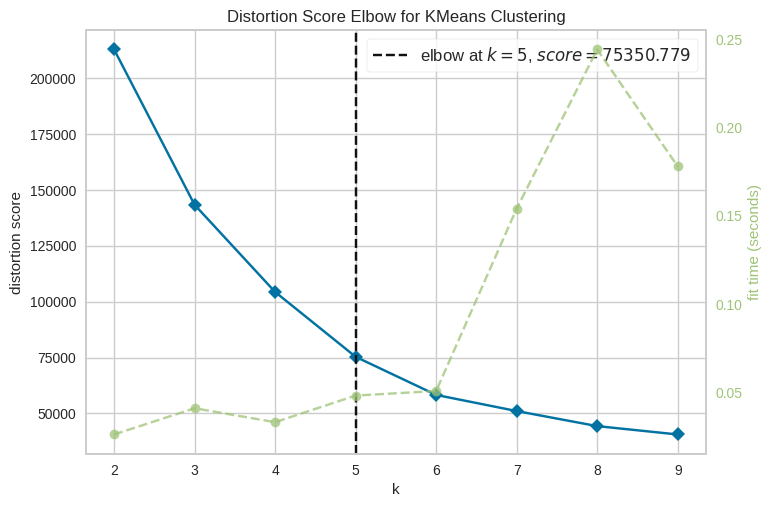

In [79]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

→ 군집 수가 증가합에 따라 왜곡 점수가 감소

→ 그러나 뚜렷한 elbow는 보이지 않음

→ 기본 알고리즘은 5개의 군집을 제안함

→ 5개 또는 6개의 군집을 선택하는 것이 공평해 보임

* 가장 좋은 군집 수를 선택하는 또 다른 방법: 군집 수 함수에 실루엣 점수를 표시하는 것

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

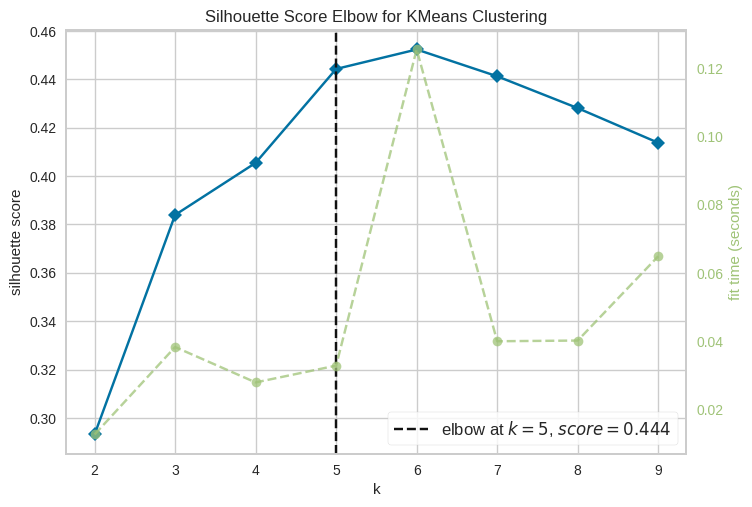

In [80]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

→ 실루엣 점수 방법은 5개 또는 6개의 군집이 가장 좋은 옵션임을 나타냄

In [81]:
# 5 clusters
KM_5_clusters = KMeans(n_clusters=5, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_ # append labels to points

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



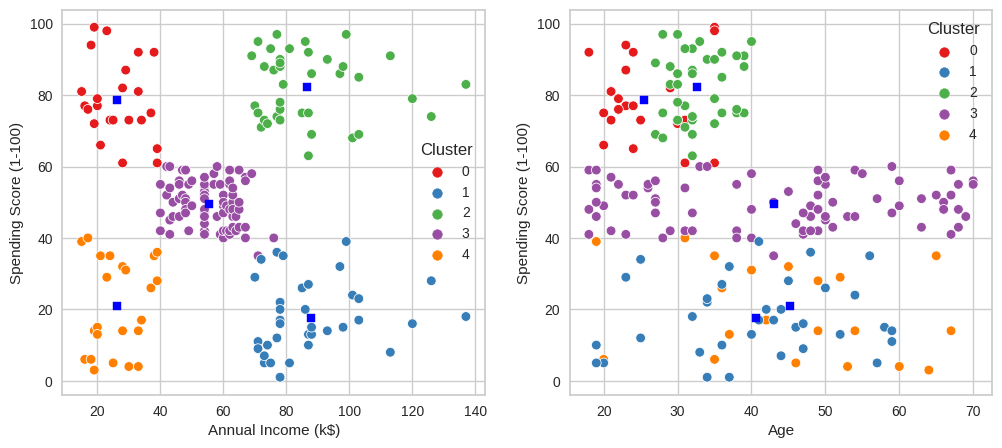

In [82]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(KM_5_clusters.cluster_centers_[:,1],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_5_clusters.cluster_centers_[:,0],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

→ 5개의 군집 생성
* clients with low annual income and high spending score
* clients with medium annual income and medium spending score
* clients with high annual income and low spending score
* clients with high annual income and high spending score
* clients with low annual income and low spending score

→ 고객의 연령에 따라 구분되는 그룹 없음

In [83]:
# clusters 크기
KM_clust_sizes = KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
Cluster,
0,23
1,36
2,39
3,79
4,23


→ 가장 큰 군집은 관측치가 79개인 군집 번호 0. 각각 23개의 관측치를 포함하는 가장 작은 관측치 두 개 존재

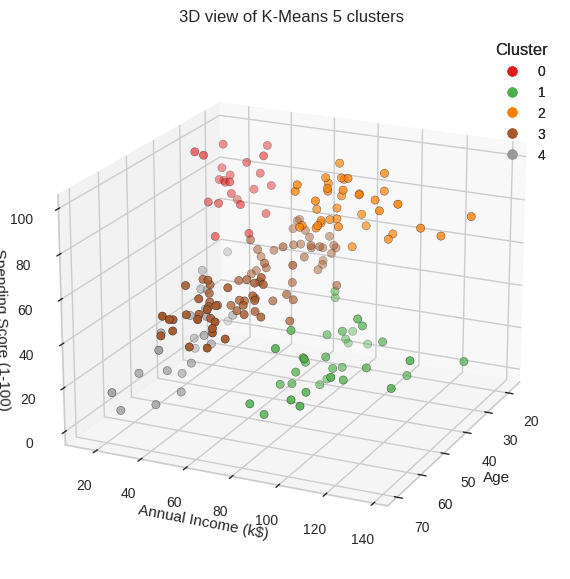

In [84]:
# 5개의 생성된 클러스터의 3D 투영
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d', elev=20, azim=210)
scatter = ax.scatter(KM5_clustered['Age'],
                     KM5_clustered['Annual Income (k$)'],
                     KM5_clustered['Spending Score (1-100)'],
                     c=KM5_clustered['Cluster'],
                     s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D view of K-Means 5 clusters')
ax.azim = 25

# Create a legend with the unique colors from the scatter
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Cluster")
ax.add_artist(legend)

plt.show()

In [85]:
import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['Cluster']==n]['Age'],
        y = db[db['Cluster']==n]['Spending Score (1-100)'],
        z = db[db['Cluster']==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 5
        )
     )

trace0 = tracer(KM5_clustered, 0, 'Cluster 0')
trace1 = tracer(KM5_clustered, 1, 'Cluster 1')
trace2 = tracer(KM5_clustered, 2, 'Cluster 2')
trace3 = tracer(KM5_clustered, 3, 'Cluster 3')
trace4 = tracer(KM5_clustered, 4, 'Cluster 4')

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



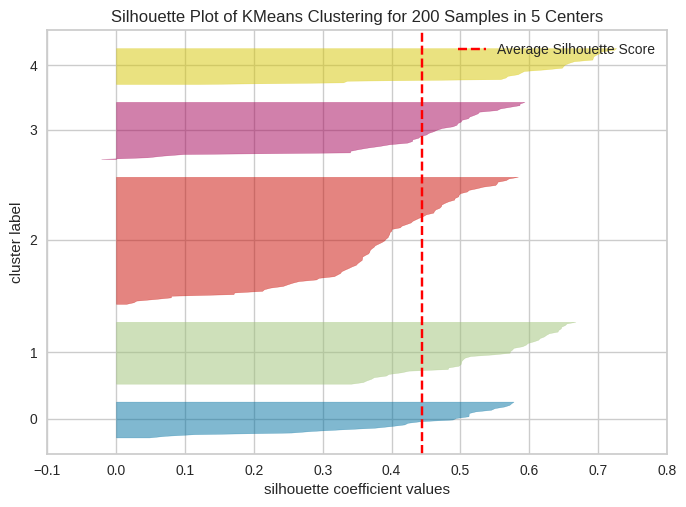

In [86]:
# Silhuette plot
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=5, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

In [87]:
# 6 clusters
KM_6_clusters = KMeans(n_clusters=6, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM6_clustered = X_numerics.copy()
KM6_clustered.loc[:,'Cluster'] = KM_6_clusters.labels_ # append labels to points

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



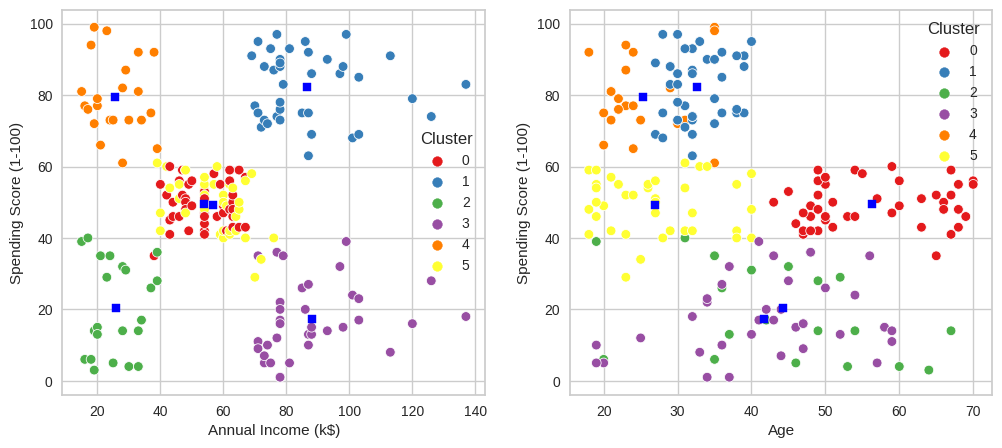

In [88]:
fig11, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

# plotting centroids
axes[0].scatter(KM_6_clusters.cluster_centers_[:,1], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_6_clusters.cluster_centers_[:,0], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

→ 6개의 군집 생성
* younger clients with medium annual and medium spending score
* clients with high annual income and low spending score
* younger clients with medium annual and medium spending score
* clients with high annual income and high spending score
* clients with low annual income and low spending score
* clients with low annual income and high spending score

→ 고객의 연령에 따라 구분되는 그룹 없음

In [89]:
KM6_clust_sizes = KM6_clustered.groupby('Cluster').size().to_frame()
KM6_clust_sizes.columns = ["KM_size"]
KM6_clust_sizes

,KM_size
Cluster,
0,44
1,39
2,22
3,35
4,22
5,38


In [90]:
# Plotly interactive 3D plot

trace0 = tracer(KM6_clustered, 0, 'Cluster 0')
trace1 = tracer(KM6_clustered, 1, 'Cluster 1')
trace2 = tracer(KM6_clustered, 2, 'Cluster 2')
trace3 = tracer(KM6_clustered, 3, 'Cluster 3')
trace4 = tracer(KM6_clustered, 4, 'Cluster 4')
trace5 = tracer(KM6_clustered, 5, 'Cluster 5')

data = [trace0, trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



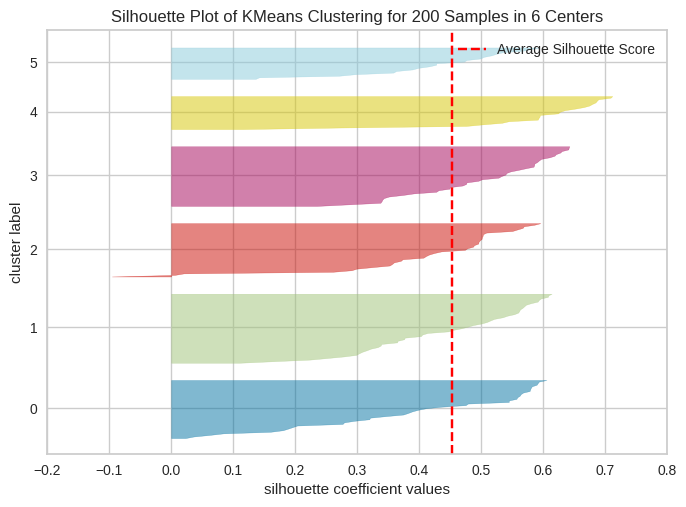

In [91]:
model = KMeans(n_clusters=6, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

###4.2 DBSCAN

Density-Based Spatial Clustering of Applications with Noise

이 장에서는 DBSCAN(노이즈가 있는 애플리케이션의 밀도 기반 공간 클러스터링)의 작동 방식 설명

####4.2.1 Description

* DBSCAN의 핵심 아이디어는 밀집 지역을 중심으로 한 개념
* 자연 클러스터들은 밀집된 위치에 있는 점들로 구성되어 있다는 것
* 이는"dense region(밀집 지역)"에 대한 정의를 필요로 하고 이를 위해서는 DBSCAN 알고리즘에 두 개의 파라미터가 필요함
  * Eps, ε - distance
  * MinPts - Minimum number of points within distance Eps
* "dense region"은 이들 모두 사이의 거리 내의 최소 점들(Eps)에 의해 생성됨. 이 거리 내에 있지만 최소 개수의 다른 지점에 근접하지 않은 지점은 "border points(경계 지점)"으로 취급. 나머지는 노이즈 또는 특이치

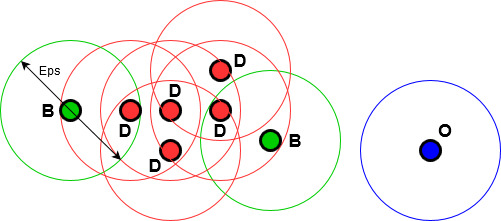

→ 적색점(D)는 밀집 영역 내에 위치하며 각 영역은 거리 Eps 내에 최소 3개의 이웃을 가짐

→ 녹색점(B)는 경계 지점이며 Eps 거리에 인접하지만 3개보다 적은 이웃을 가짐

→ 푸른점(O)는 outlier로 distance Eps 영역 안에 이웃 없음

* 장점
  * it finds number of clusters itself, based on eps and MinPts parameters
  * It it able to differentiate elongated clusters or clusters surrounded by other clusters in contrary to e.g. K-Means where clusters are always convex.
  * It is also able to find points not fitting into any cluster – it detects outliers.

* DBSCAN의 단점
  * High computational expense of average O(n log(n)) coming from a need to execute a neighbourhood query for each point.
  * Poorly identifies clusters with various densities

####4.2.2 Use case - customers segmentation

In [92]:
from sklearn.cluster import DBSCAN

* DBSCAN에의 두 가지 주요 하이퍼파라미터:
  * eps
  * min_samples

In [93]:
# create a matrix of investigated combinations
from itertools import product

eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))

In [94]:
# DBSCAN은 두 파라미터를 기반으로 클러스터를 자체적으로 생성하므로 생성된 클러스터 수 확인
from sklearn.metrics import silhouette_score

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_numerics)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))

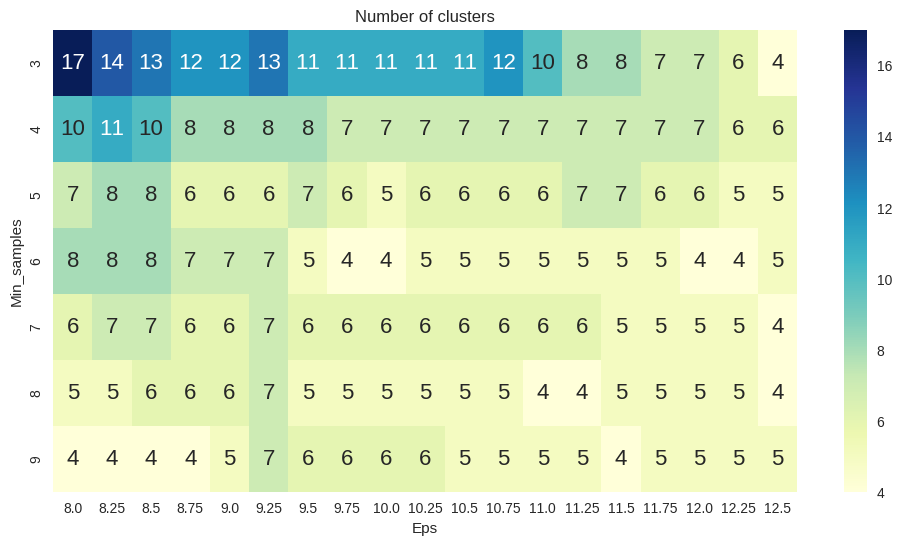

In [95]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

→ 군집의 수가 17개 에서 4개까지 다양, 대부분의 조합은 4-7개의 군집을 제공

→ 어떤 조합을 고를지 정하기 위해 실루엣 점수 사용, 다시 heatmap plot

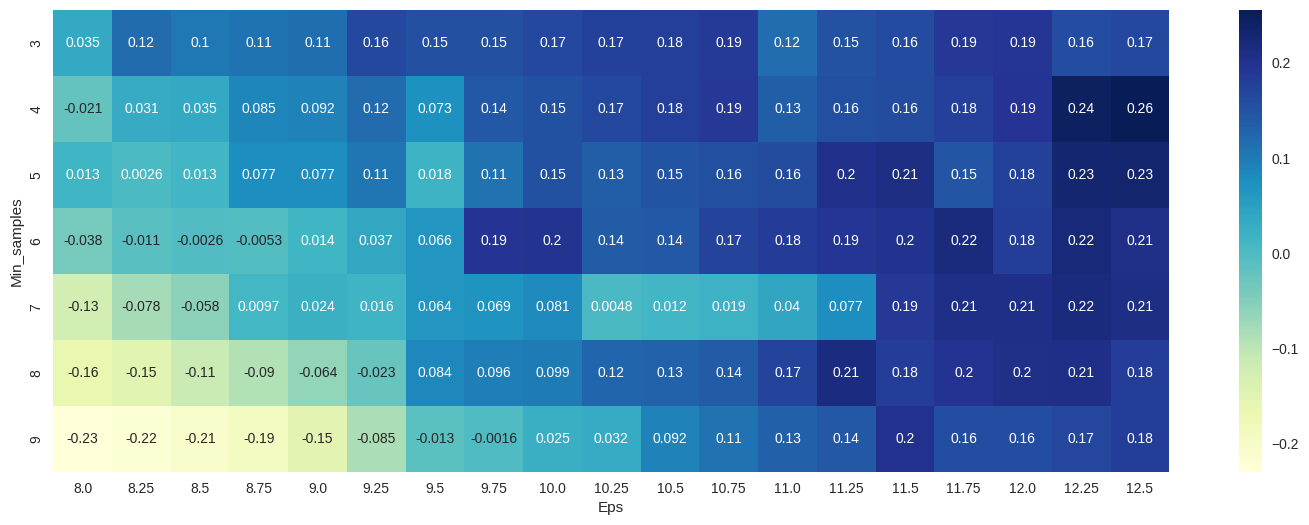

In [96]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

→ Global maximum is 0.26 for eps=12.5 and min_samples=4

In [97]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

In [98]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


→ DBSCAN에서 5개의 군집과 특이치 군집(-1) 생성

→ 군집 0-4의 크기는 매우 다양

→ 일부 군집은 관측치가 4개 또는 8개뿐. 특이치는 18개

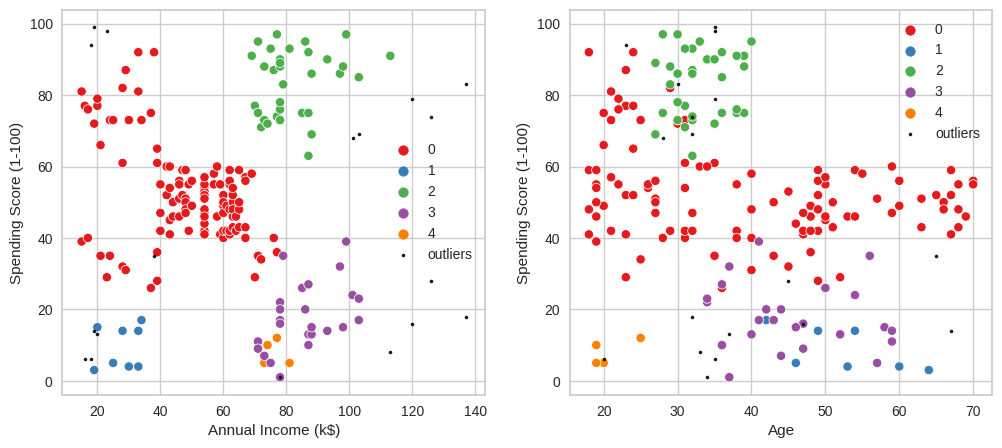

In [99]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot(x='Age', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

→ 위 그래프는 일부 특이치가 있음을 보여줌

→ 이 점들은 군집으로 인식되기 위한 거리 및 최소 표본 요구 조건을 충족하지 못함

###4.3 Affinity Propagation

선호도 전파의 작동 방식

####4.3.1 Description

* Affinity Propagation: 한 쌍의 포인트 간에 메시지가 수렴할 때까지 메시지를 보내는 개념을 기으로 구축되는 클러스터링 알고리즘
* 최적의 클러스터 수를 자체적으로 찾음
* 사용자는 두 파라미터를 지정해야 함:
  * 선호도 - 음수, 사용되는 표의 수를 조절함
  * Damping factor - 메시지 업데이트시 수치 진동을 방지

####4.3.2 Use case - customers segmentation

In [100]:
from sklearn.cluster import AffinityPropagation

In [101]:
no_of_clusters = []
preferences = range(-20000,-5000,100) # arbitraty chosen range
af_sil_score = [] # silouette scores

for p in preferences:
    AF = AffinityPropagation(preference=p, max_iter=200).fit(X_numerics)
    no_of_clusters.append((len(np.unique(AF.labels_))))
    af_sil_score.append(silhouette_score(X_numerics, AF.labels_))

af_results = pd.DataFrame([preferences, no_of_clusters, af_sil_score], index=['preference','clusters', 'sil_score']).T
af_results.sort_values(by='sil_score', ascending=False).head() # display only 5 best scores

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



,preference,clusters,sil_score
82,-11800.0,6.0,0.451649
27,-17300.0,6.0,0.451491
51,-14900.0,6.0,0.451491
52,-14800.0,6.0,0.451440
28,-17200.0,6.0,0.451440


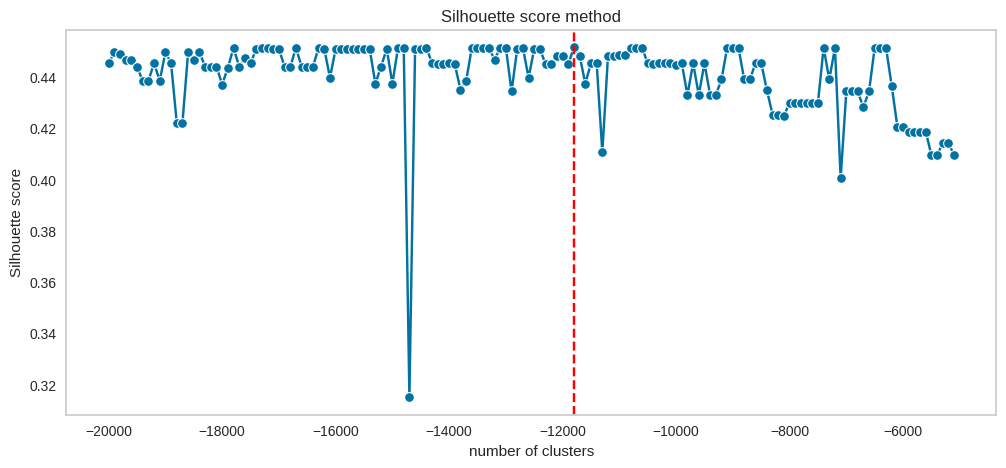

In [102]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(x=preferences, y=af_sil_score, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(-11800, ls="--", c="red")
plt.grid()
plt.show()

In [103]:
AF = AffinityPropagation(preference=-11800).fit(X_numerics)

In [104]:
AF_clustered = X_numerics.copy()
AF_clustered.loc[:,'Cluster'] = AF.labels_ # append labels to points

In [105]:
AF_clust_sizes = AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns = ["AF_size"]
AF_clust_sizes

,AF_size
Cluster,
0,22
1,22
2,44
3,39
4,34
5,39


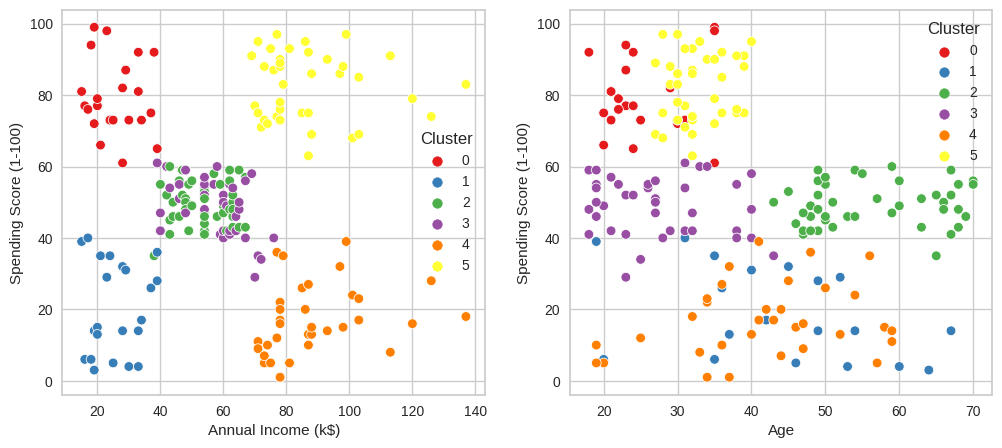

In [106]:
fig3, (ax_af) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', ax=ax_af[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', palette='Set1', ax=ax_af[1], legend='full')

plt.setp(ax_af[0].get_legend().get_texts(), fontsize='10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize='10')
plt.show()

→ 친화도 전파 알고리즘에 의해 생성된 클러스터는 K-Means에 의해 생성된 것과 유사한 비교적 고른 크기의 클러스터를 생성함

##5. Comparison and discussion

3가지 알고리즘 비교

* K-Menas

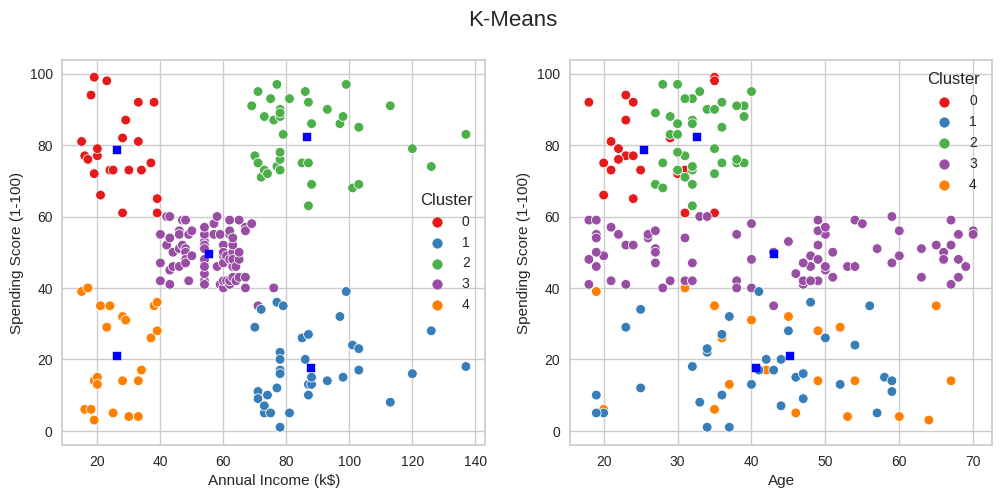

In [107]:
# 클러스터 5개
fig1.suptitle('K-Means', fontsize=16)
fig1

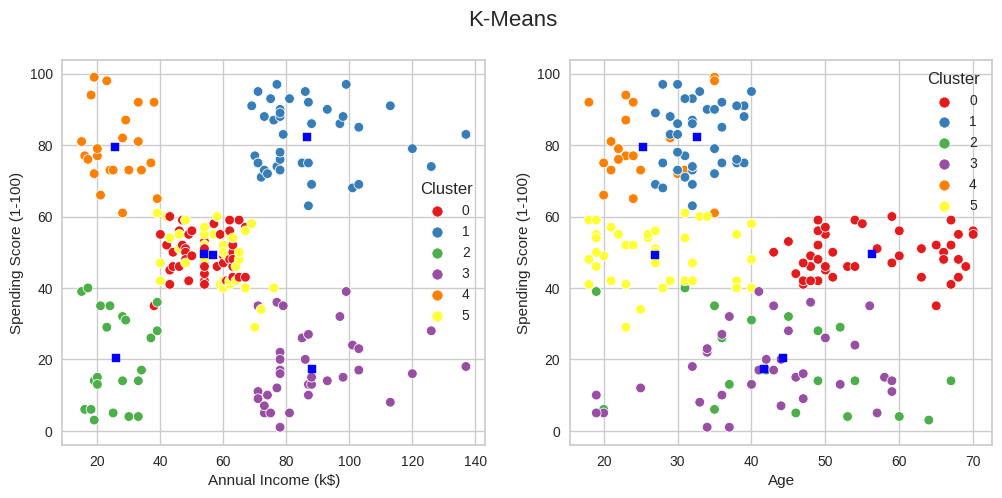

In [108]:
# 클러스터 6개
fig11.suptitle('K-Means', fontsize=16)
fig11

* DBSCAN

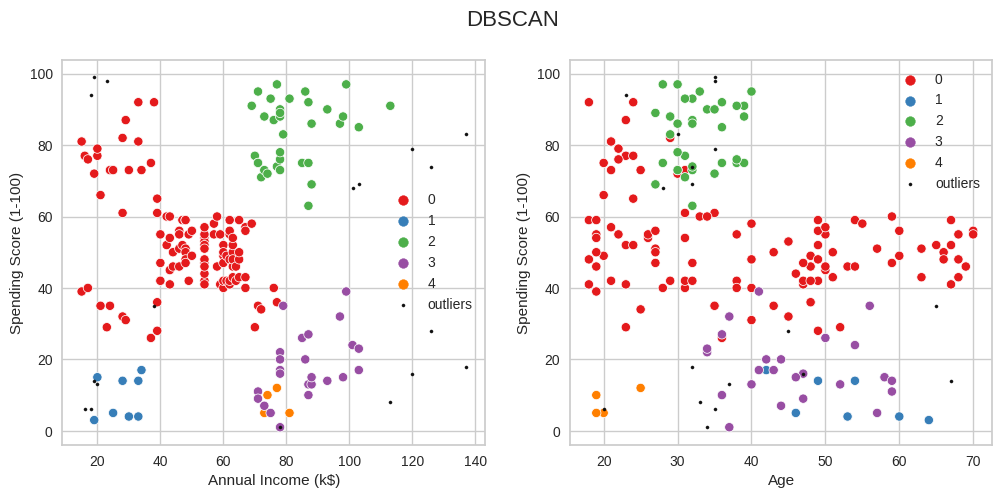

In [109]:
fig2.suptitle('DBSCAN', fontsize=16)
fig2

* Affinity Propagation

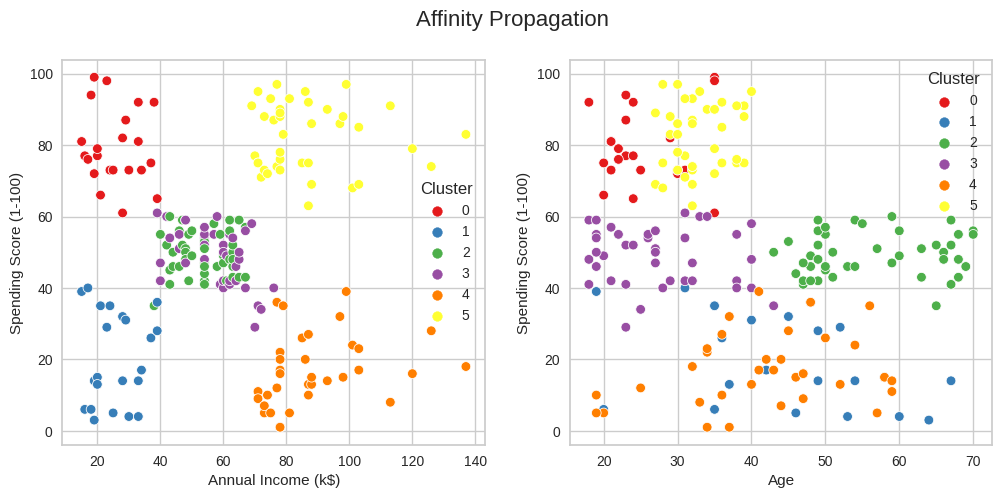

In [110]:
fig3.suptitle('Affinity Propagation', fontsize=16)
fig3

In [111]:
clusters = pd.concat([KM6_clust_sizes, DBSCAN_clust_sizes, AF_clust_sizes],axis=1, sort=False)
clusters

,KM_size,DBSCAN_size,AF_size
Cluster,,,
0,44.0,112.0,22.0
1,39.0,8.0,22.0
2,22.0,34.0,44.0
3,35.0,24.0,39.0
4,22.0,4.0,34.0
5,38.0,NaN,39.0
-1,NaN,18.0,NaN


→ 생성된 클러스터의 크기. 클러스터 번호 지정은 각 방법마다 다름

→ 위 비교를 통해, DBSCAN이 합리적인 클러스터를 생성하지 못했음을 알 수 있음(DBSCAN이 점의 밀도를 기반으로 클러스터를 찾으려 하기 떄문일 가능성이 큼)

→ 클러스터 중 하나가 다른 클러스터보다 밀도가 낮은 경우 DBSCAN은 최소 밀도 그룹을 클러스터로 인식하지 않음으로써 차선의 결과를 생성함

→ 결국 K-Means와 Affinity Propagation 알고리즘은 합리적인 6개의 클러스터를 생성함